In [1]:
import os
import numpy as np

import torch

from pathlib import Path

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import colors

import sys

from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/'))) 
from encoder1 import recon_model

# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../NN/ptychosaxsNN/')))
import utils.ptychosaxsNN_utils as ptNN_U

import importlib
importlib.reload(ptNN_U)

<module 'utils.ptychosaxsNN_utils' from '/home/beams0/PTYCHOSAXS/NN/ptychosaxsNN/utils/ptychosaxsNN_utils.py'>

In [2]:
#Load lowest validation loss model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_new=recon_model()
model_new.load_state_dict(torch.load("/net/micdata/data2/12IDC/ptychosaxs/trained_model/best_model_ZCB_9.pth"))
model_new.to(device)

#put into eval mode
model_new.eval()

recon_model(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): R

In [3]:
# load ZCB_9_3D diffraction data
base_path="/net/micdata/data2/12IDC/2025_Feb/ptycho/"
scan_numbers=[5065]#np.arange(5004,5189,1)#[5045,5065,5102,5150]
all_dps=[]
for scan_number in scan_numbers:
    print(f"Loading scan {scan_number}")
    dps=ptNN_U.load_h5_scan_to_npy(base_path, scan_number, plot=False,point_data=True)
    all_dps.append(dps)
all_dps=np.asarray(all_dps)

Loading scan 5065


100%|██████████| 1043/1043 [00:33<00:00, 31.10it/s]


In [4]:
#summed diffraction pattern
print(all_dps.shape)
dp=np.sum(all_dps[0],axis=0)

(1, 1043, 1043, 981)


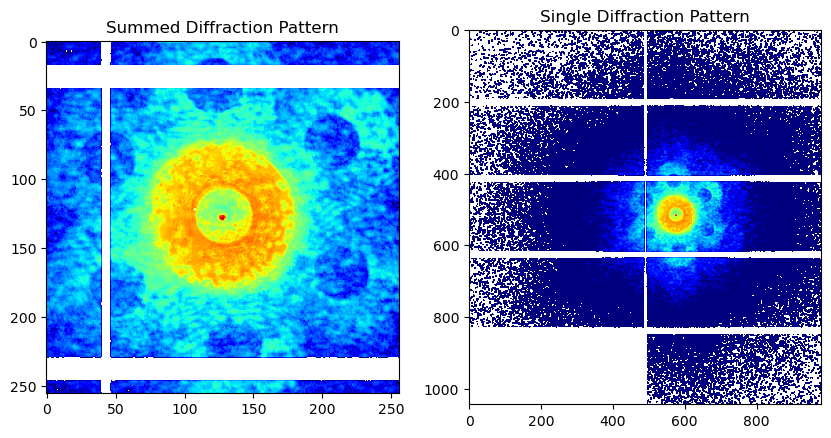

In [5]:
#scan informtion
ncols=36
nrows=29
center=(517,575)

#crop diffraction patterns
dpsize=256
dp=dp[center[0]-dpsize//2:center[0]+dpsize//2,
    center[1]-dpsize//2:center[1]+dpsize//2]
dp=dps[666][center[0]-dpsize//2:center[0]+dpsize//2,
    center[1]-dpsize//2:center[1]+dpsize//2]
#plot diffraction patterns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(dp, cmap='jet',norm=colors.LogNorm())
axs[0].set_title('Summed Diffraction Pattern')
axs[1].imshow(dps[666], cmap='jet',norm=colors.LogNorm())
axs[1].set_title('Single Diffraction Pattern')
plt.show()


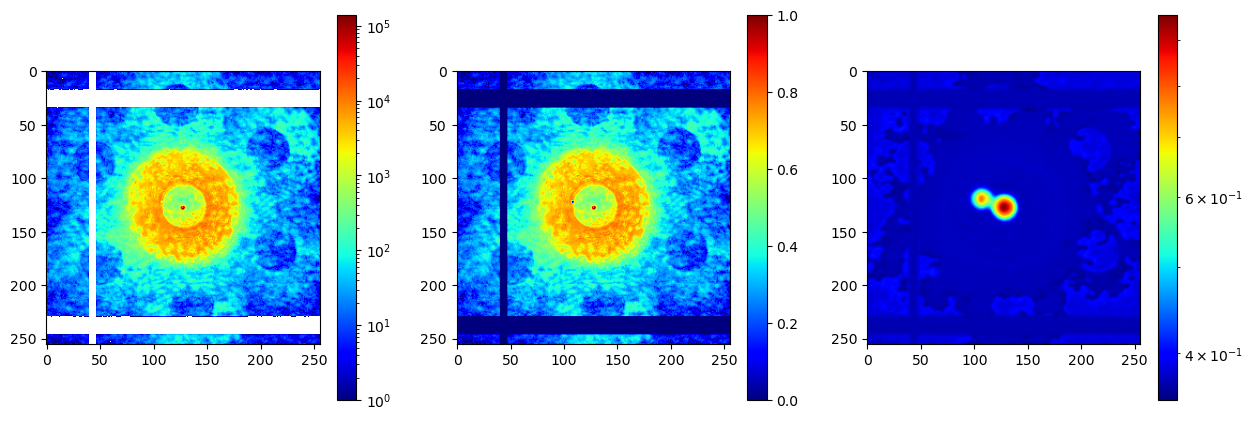

In [ ]:
#preprocess diffraction pattern
mask = np.load('/home/beams/PTYCHOSAXS/deconvolutionNN/data/mask/mask_ZCB_9_3D.npy')
resultT, sfT, bkgT = ptNN_U.preprocess_ZCB_9(dp, mask)

#plot diffraction pattern and deconvolved pattern
fig,ax=plt.subplots(1,3,figsize=(15,5))
im1=ax[0].imshow(dp,norm=colors.LogNorm(),cmap='jet')
im2=ax[1].imshow(resultT[0][0],cmap='jet')
im3=ax[2].imshow(model_new(resultT.to(device=device, dtype=torch.float)).detach().to("cpu").numpy()[0][0],cmap='jet')
plt.colorbar(im1)
plt.colorbar(im2)
plt.colorbar(im3)
plt.show()